In [0]:
# Path
import os

# Data
import numpy as np

# Image
from PIL import Image # used in image processing function

# Tensorflow
from tensorflow.keras.preprocessing.image import (
    img_to_array,
    load_img
)

# Google Drive
from google.colab import drive


# Colab Function

In [0]:
def gpu_check():
  """
      Check GPU RAM status. Since google colab share gpu resource amount of its
      user, you want to make sure there are enough GPU RAM that are free to use.
      Recommend at least 3000MB free GPU RAM.
  """
  # memory footprint support libraries/code
  !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
  !pip install gputil
  !pip install psutil
  !pip install humanize
  import psutil
  import humanize
  import os
  import GPUtil as GPU
  GPUs = GPU.getGPUs()
  # XXX: only one GPU on Colab and isn’t guaranteed
  gpu = GPUs[0]
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [0]:
def mount_drive():
  """
      Mount your google drive to google colab, so that you can access the
      dataset via google drive.
      
      YOUR DIR PATH SHOULD BE: drive/"Colab Notebooks"

  #Giving colab permission to access drive
  !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
  !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
  !apt-get update -qq 2>&1 > /dev/null
  !apt-get -y install -qq google-drive-ocamlfuse fuse
  from google.colab import auth
  auth.authenticate_user()
  from oauth2client.client import GoogleCredentials
  creds = GoogleCredentials.get_application_default()
  import getpass
  !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
  vcode = getpass.getpass()
  !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

  #Note: if you get an error :  “apt-key output should not be parsed (stdout is not a terminal)” Warning
  # it means that permission has been already granted

  #Mount drive
  !mkdir -p drive
  !google-drive-ocamlfuse drive
  """
  drive.mount('/content/gdrive')
  

# Config

In [0]:
"""
    config project in this cell.
"""

# Env, where you running this project
# Google colab: 'colab'
env = 'colab'

# size of sub image
size = 33

# strde when crop image
stride = 14

# upscaling factor
up_scale = 3



In [5]:
"""
    YOU SHOULD NOT CHANGE ANY THING IN THIS CELL.
"""

# config dictionary
config = {
    'colab':{
        'data_dir':'/content/gdrive/My Drive/Colab Notebooks/data'
    }
}

# setting all variables
data_dir = config[env]['data_dir']

if env == 'colab':
  # mount google dirve
  mount_drive()
  # check GPU
  gpu_check()


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 304.2 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


# Import Section

# Image Processing Function

In [0]:
def array_to_img(x, mode='YCbCr'):
  """
      Convert array to image using YCbCr color
      
      Args:
        x: array of image.
        mode: channel mode, default to 'YCbCr'
              1 (1-bit pixels, black and white, stored with one pixel per byte)
              L (8-bit pixels, black and white)
              P (8-bit pixels, mapped to any other mode using a color palette)
              RGB (3x8-bit pixels, true color)
              RGBA (4x8-bit pixels, true color with transparency mask)
              CMYK (4x8-bit pixels, color separation)
              YCbCr (3x8-bit pixels, color video format)
              Note that this refers to the JPEG, and not the ITU-R BT.2020, standard
              LAB (3x8-bit pixels, the L*a*b color space)
              HSV (3x8-bit pixels, Hue, Saturation, Value color space)
              I (32-bit signed integer pixels)
              F (32-bit floating point pixels)
  """
  return Image.fromarray(x.astype('uint8'), mode=mode)


def bicubic_rescale(image, scale):
  """
      Rescale image using bicubic interpolation.
      
      Args:
        image: image
        scale: use integer for up scaling. use 1/integer for down scaling
  """
  # make sure scale is valid
  if isinstance(scale, (float, int)):
    size = (np.array(image.size) * scale).astype(int)
  return image.resize(size, resample=Image.BICUBIC)


def modcrop(image, scale):
  """
      To scale down the original image, there must be no remainder while scaling
      operation.
      
      All we want to do in here is to subtract the remainder from height and 
      width of original image size, and cut the original image to the new size.
      
      Args:
        image: original image
        scale: must be int
  """
  if not isinstance(scale, int):
    raise Exception('utils.modcrop: scale must be int')
  size = np.array(image.size)
  size -= size % scale
  return image.crop([0, 0, *size])

# Data Preprocessing

In [0]:
def load_image_pair(path, scale=3):
  """
      Down scaling a hight resolution image to a low resolution image and
      return both of them.
      
      Args:
        path: image path
        scale: scale of down scaling, must be a int
  """
  image = load_img(path)
  image = image.convert('YCbCr')
  hr_image = modcrop(image, scale)
  lr_image = bicubic_rescale(hr_image, 1 / scale)
  return lr_image, hr_image


def generate_sub_images(image, size, stride):
  """
      Cut image into sub images.
      
      Args:
        image: image
        size: size of sub image
        stride: distance of how much the window shifts by in each of the 
                dimensions
  """
  for i in range(0, image.size[0] - size + 1, stride):
        for j in range(0, image.size[1] - size + 1, stride):
            # yield return a generator, or a list of number
            yield image.crop([i, j, i + size, j + size])


def load_set(dataset_name, lr_sub_size, lr_sub_stride, scale):
  """
      Load all image from a directory and cut them into small sub image.
      
  """
  if not all(isinstance(i, int) for i in [lr_sub_size, lr_sub_stride, scale]):
    raise Exception('utils.load_set: lr_sub_size, stride, scale must be int')
    
  # compute parameters for hight resolution image
  hr_sub_size = lr_sub_size * scale
  hr_sub_stride = lr_sub_stride * scale

  lr_sub_arrays = []
  hr_sub_arrays = []
  for file_name in os.listdir(os.path.join(data_dir, dataset_name)):
    path = os.path.join(data_dir, dataset_name, file_name)
    lr_image, hr_image = load_image_pair(str(path), scale=scale)
    lr_sub_arrays += [img_to_array(img) for img in generate_sub_images(lr_image, size=lr_sub_size, stride=lr_sub_stride)]
    hr_sub_arrays += [img_to_array(img) for img in generate_sub_images(hr_image, size=hr_sub_size, stride=hr_sub_stride)]
  
  # convert list to np.array
  x = np.stack(lr_sub_arrays)
  y = np.stack(hr_sub_arrays)
  
  return x, y

(197, 197)
197
197


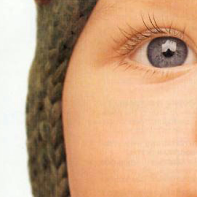

In [13]:
# just an example, will be deleted later
l, h = load_set('Set5', 197, 50, 1)
img = array_to_img(l[3])
img.convert(mode='RGB')

# Model

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import SGD, Adam

def train_model(input_image, f1, n1, n2, f3):
  '''
  input_image: the sub-image of label y, better in 32 x 32
  f1: filter size(must be odd #), f1 x f1 
  n1: the number of filter apply on layer 1.
  n2: the number of filter apply on layer 2.
  f3: filter size(must be odd #), f3 x f3 where
  factor: upscaling factor 
  '''  
  
  m, n = input_image.size
  
  model = Sequential([
      Conv2D(filters=n1, kernel_size=f1, padding='same', bias_initializer='zeros',
             use_bias=True,activation='relu', input_shape=(m,n,1)),
      Conv2D(filters=n2, kernel_size=1, padding='same',
             use_bias=True,activation='relu',bias_initializer='zeros'),
      Conv2D(filters=1, #filter here need to match the channel
             kernel_size=f3, padding='same', bias_initializer='zeros',
             use_bias=True,activation='relu',)])
  
  # either SGD or Adam, paper used SGD, but Adam used widely
  optimizer = SGD(lr=0.0003)
  #optimizer = Adam(lr=0.0003)
  model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
  
  return model

print(train_model(img,9,64,32,5))